# Data 512 : A1 : Data Curation
<i>The following text is taken from the assignment:</i>

For this assignment, you combine data about Wikipedia page traffic from two different Wikimedia REST API (Links to an external site.) endpoints into a single dataset, perform some simple data processing steps on the data, and then analyze that data.

The goal of this assignment is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1 2008 through August 30 2020. All analysis should be performed in a single Jupyter notebook and all data, documentation, and code should be published in a single GitHub repository.

The purpose of the assignment is to start to familiarize you with the Jupyter Notebook environment and with some best practices for open scientific research in designing and implementing your project, and make your project fully reproducible by others: from data collection to data analysis.

# Step 1: Gathbering the data
This section of the notebook focuses on gathering the data from the APIs of interest.

First we define the set of constants we need.

In [1]:
import json
import requests

# path to output the json results to 
output_path = "."

# Wikipedia endpoints for API request data in aggregate
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

# start and end times for the data to collect
start_time = "2008010100"
end_time = "2020080100"

# project name that we care about -- english Wikipedia
project = "en.wikipedia.org"

# The access types for pageviews api
access_types_for_page_views = [
    "all-access",
    "desktop",
    "mobile-app",
    "mobile-web"
]

# The access types for pagecounts api
access_types_for_page_counts = [
    "all-sites",
    "desktop-site",
    "mobile-site"
]

# The headers to use for user-agent for the API requests
headers = {
    'User-Agent': 'https://github.com/hkulkar',
    'From': 'hkulkar@uw.edu'
}

apis = ["pagecounts", "pageviews"]

Next, we define the set of functions which will get data from the APIs and store them in files which follow the naming convention :

   apiname_accesstype_firstmonth-lastmonth.json

In [2]:
import json

def get_pagecounts_params(access_type):
        return  {"project" : project,
                     "access-site" : access_type,
                     "granularity" : "monthly",
                     "start" : start_time,
                    # for end use 1st day of month following final month of data
                     "end" : end_time
                    }

def get_pageviews_params(access_type):
    return {"project" : project,
                "access" : access_type,
                "agent" : "user",
                "granularity" : "monthly",
                "start" : start_time,
                # for end use 1st day of month following final month of data
                "end" : end_time
                    }

def api_call(endpoint,parameters):
    '''
        Sends an API request to the 'endpoint' with the given 'parameters'
        :param endpoint: the endpoint to send the api request to
        :param parameters: the json parameters to send an api request to
        :returns: the JSON response object from the API.
    '''
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

def write_str_to_file(file_path, s):
    '''
        Writes the string 's' to the file specified by file_path
        :param file_path: the file path to write to.
        :param s: the string to write to the file.
    '''
    f = open(file_path, 'wt', encoding='utf-8')
    f.write(s)
    f.close()

def write_api_result_to_files(api_to_request):
    '''
        Runs the speciifed api according to 'api_request' and gets the required types of data from it. Then stores the files in
        the '../data' folder with the file name {api_to_request}_{accesstype}_{firstmonth}-{lastmonth}.json
        :param api_to_request: either 'pagecounts' or 'pageviews' otherwise throws ValueError
    '''
    access_types = None
    get_params = None
    endpoint = None
    
    if api_to_request == "pagecounts":
        access_types = access_types_for_page_counts
        get_params = get_pagecounts_params
        endpoint = endpoint_legacy
    elif api_to_request == "pageviews":
        access_types = access_types_for_page_views
        get_params = get_pageviews_params
        endpoint = endpoint_pageviews
    else:
        raise ValueError("You provided api_to_request={api_to_request}. But only 'pageviews' and 'pagecounts' are allowed.")
    
    for access_type in access_types:
        params = get_params(access_type)
        response = api_call(endpoint, params)
        file_name = f"{api_to_request}_{access_type}_{params['start'][:6]}-{params['end'][:6]}.json"
        f = open(f"{output_path}/{file_name}", "wt", encoding="utf-8")
        f.write(json.dumps(response))
        f.close()

Now for each API we write the data to files.

In [3]:
for api in apis:
    write_api_result_to_files(api)

# Step 2: Processing the data
Now we perform a series of processing steps o the data to prepare it for analysis.

First load the data from the json files

In [4]:
import json
import os

from os import listdir
from os.path import isfile, join
onlyfiles = [join(output_path, f) for f in listdir(output_path) if isfile(join(output_path, f))]
apis_to_files = {k:[f for f in onlyfiles if k in f] for k in apis}
apis_to_files    

{'pagecounts': ['.\\pagecounts_all-sites_200801-202008.json',
  '.\\pagecounts_desktop-site_200801-202008.json',
  '.\\pagecounts_mobile-site_200801-202008.json'],
 'pageviews': ['.\\pageviews_all-access_200801-202008.json',
  '.\\pageviews_desktop_200801-202008.json',
  '.\\pageviews_mobile-app_200801-202008.json',
  '.\\pageviews_mobile-web_200801-202008.json']}

In [5]:
apis_to_dfs = {k:None for k in apis}

import pandas as pd
for api,files in apis_to_files.items():
    for f in files:
        current_df = apis_to_dfs[api]
        
        f_as_json = None
        with open(f) as f:
            f_as_json = json.loads(f.read())['items']
        if current_df is None:
            current_df = pd.DataFrame(f_as_json)
        else:
            current_df = pd.concat((current_df, pd.DataFrame(f_as_json)))
        apis_to_dfs[api] = current_df


For Pageviews API combine the monhtly values for mobile-app and mobile web to create total mobile traffic count for each month

In [6]:
df = apis_to_dfs["pageviews"]
df.loc[df["access"].str.startswith("mobile"), "access"] = "mobile" 
df["access"].unique()

array(['all-access', 'desktop', 'mobile'], dtype=object)

Drop columns from Pageview dataframe which aren't required.

In [7]:
df.columns

Index(['project', 'access', 'agent', 'granularity', 'timestamp', 'views'], dtype='object')

In [8]:
df= df.drop(columns=["granularity", "agent", "project"])
df["api_name"] = "pageview"
apis_to_dfs["pageviews"] = df

In [9]:
apis_to_dfs["pageviews"].columns

Index(['access', 'timestamp', 'views', 'api_name'], dtype='object')

Standardize the pagecounts data to have the same column names

In [10]:
df = apis_to_dfs["pagecounts"]
df.columns

Index(['project', 'access-site', 'granularity', 'timestamp', 'count'], dtype='object')

In [11]:
df = df.rename(columns={"access-site":"access", "count":"views"}).drop(columns=["granularity", "project"])

In [12]:
df["api_name"] = "pagecount"

In [13]:
df.columns

Index(['access', 'timestamp', 'views', 'api_name'], dtype='object')

Concatenate the datasets together

In [14]:
df = pd.concat((apis_to_dfs["pageviews"], df))

standardize the access type names

In [15]:
df.loc[df["access"].str.startswith("mobile"), "access"] = "mobile" 
df.loc[df["access"].str.startswith("all"), "access"] = "all" 
df.loc[df["access"].str.startswith("desktop"), "access"] = "desktop" 
df["access"].unique()

array(['all', 'desktop', 'mobile'], dtype=object)

Now standardize the access names into their column names in the final schema

In [16]:
df["access"] = df["api_name"] + "_" + df["access"] + "_views"

Now groupby to remove any duplicates

In [17]:
df = df.groupby(["timestamp", "access"])["views"].sum().reset_index()
df.head(1)

,timestamp,access,views
0,2008010100,pagecount_all_views,4930902570


Now pivot the dataframe to get the access type views as columns.

In [18]:
df = df.pivot(index="timestamp", columns="access", values="views").reset_index()

For any data fill that value in as 0's

In [19]:
df = df.fillna(0)

Break apart the year and month, and remove timestamp

In [20]:
df['year'] = df['timestamp'].str[:4].apply(int)
df['month'] = df['timestamp'].str[4:6].apply(int)
df.head(1)

access,timestamp,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views,year,month
0,2008010100,4.930903e+09,4.930903e+09,0.0,0.0,0.0,0.0,2008,1


In [21]:
df = df.drop(columns='timestamp')

Now let's save the data to a csv

In [22]:
df.to_csv(f"{output_path}/en-wikipedia_traffic_200712-202008.csv", index=False)

# Step 3: Analyze the data
Here we graph the data similarly to as shown in the homework.

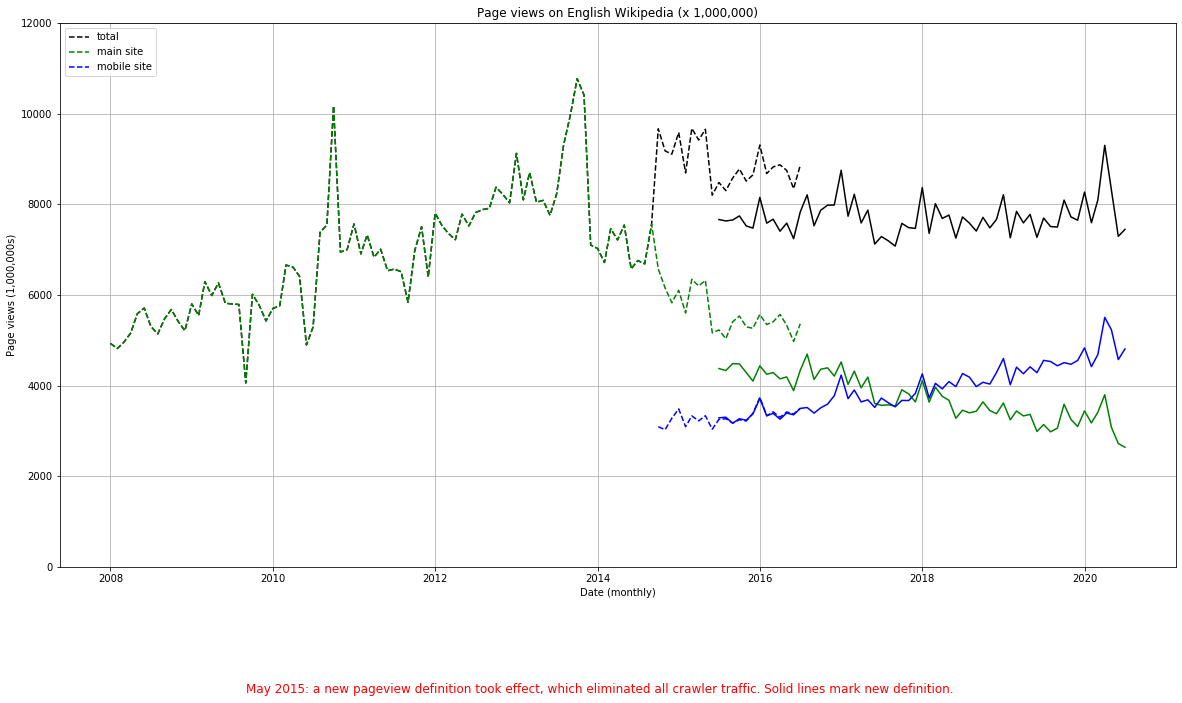

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df['date'] = df.apply(lambda row: pd.Timestamp(year=int(row['year']), month=int(row['month']), day=1), axis=1)
df = df.replace({'0':np.nan, 0:np.nan})
scale = 1000000.0
plt.figure(figsize=(20,10))
for view_col in [c for c in df.columns if c.endswith("views")]:
    label = "total"
    color = "black"
    df_to_plot = df
    if "desktop" in view_col:
        label = "main site"
        color = "green"
    elif "mobile" in view_col:
        label = "mobile site"
        color = "blue"
    linestyle = "--"
    if view_col.startswith("pageview"):
        linestyle = "-"
        label=None
    else:
        df_to_plot = df[df["date"] < pd.Timestamp(year=2016, month=8, day=1)] # data ater 2016-08-01 for legacy API is not complete.
    plt.plot(df_to_plot['date'], df_to_plot[view_col] / scale, label=label, color=color, linestyle=linestyle)
plt.grid(True)
plt.ylim(0, 12000)
plt.legend(loc='upper left')
# add the title to the plot
plt.title("Page views on English Wikipedia (x 1,000,000)")
plt.xlabel("Date (monthly)")
plt.ylabel("Page views (1,000,000s)")
# Add caption to clarify data change
txt="May 2015: a new pageview definition took effect, which eliminated all crawler traffic. Solid lines mark new definition."
plt.gcf().text(.5, -0.05, txt, ha='center', color="red", fontsize=12)
plt.show()
